In [1]:
import sys
import os

# Step 1: Get current directory 
current_directory = os.getcwd()        # '/home/bear-b/users/jshi008/IvyProjects/FIDLA/train_WaLeF_models'

# Step 2: Get path of parent directory (one level up)
parent_directory = os.path.dirname(current_directory)    # '/home/bear-b/users/jshi008/IvyProjects/FIDLA'

# Step 3: Append parent directory to sys.path
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess.BaselinePrerocess import baseline_process
from baselines.rcnn import rcnn

2023-08-03 12:17:42.412055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 12:17:43.806432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [7]:
# ===== model parameters ======
rnn_unit = 64
cnn_unit = 32
dropout = 0.2
l1_reg = 0
l2_reg = 1e-5
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512
input_shape = train_X_mask.shape[1:]

In [8]:
model = rcnn(input_shape, rnn_unit, cnn_unit, kernel_size, l1_reg, l2_reg, dropout, masked_value)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking (Masking)           (None, 96, 16)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 96, 64)            5184      
                                                                 
 dropout (Dropout)           (None, 96, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            4128      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 32)            0         
 D)                                                              
                                                             

2023-08-03 12:17:55.374961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10128 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


In [9]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_rcnn.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([test_X_mask], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-08-03 12:18:11.268046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-03 12:18:12.270825: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcb4401aee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-03 12:18:12.270890: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-08-03 12:18:12.281992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-03 12:18:12.630378: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.15727, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 21s - loss: 0.0338 - mae: 0.1349 - val_loss: 0.0369 - val_mae: 0.1573 - 21s/epoch - 136ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.15727 to 0.11233, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 13s - loss: 0.0092 - mae: 0.0712 - val_loss: 0.0189 - val_mae: 0.1123 - 13s/epoch - 88ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.11233 to 0.09213, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 13s - loss: 0.0056 - mae: 0.0536 - val_loss: 0.0134 - val_mae: 0.0921 - 13s/epoch - 85ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.09213 to 0.07441, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 12s - loss: 0.0042 - mae: 0.0451 - val_loss: 0.0093 - val_mae: 0.0744 - 12s/epoch - 82ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.07441 to 0.06306, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 13s - loss: 0.0034 - mae: 0.0394 - val_loss: 0.0070 - val_mae: 0.0631 - 13s/epoch - 85ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.06306 to 0.05622, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 13s - loss: 0.0029 - mae: 0

151/151 - 13s - loss: 6.1743e-04 - mae: 0.0132 - val_loss: 0.0015 - val_mae: 0.0290 - 13s/epoch - 83ms/step
Epoch 42/3000

Epoch 42: val_mae did not improve from 0.02883
151/151 - 13s - loss: 6.0096e-04 - mae: 0.0130 - val_loss: 0.0015 - val_mae: 0.0290 - 13s/epoch - 84ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.02883 to 0.02862, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 13s - loss: 5.8638e-04 - mae: 0.0129 - val_loss: 0.0015 - val_mae: 0.0286 - 13s/epoch - 86ms/step
Epoch 44/3000

Epoch 44: val_mae did not improve from 0.02862
151/151 - 13s - loss: 5.7034e-04 - mae: 0.0128 - val_loss: 0.0015 - val_mae: 0.0289 - 13s/epoch - 84ms/step
Epoch 45/3000

Epoch 45: val_mae did not improve from 0.02862
151/151 - 13s - loss: 5.5588e-04 - mae: 0.0127 - val_loss: 0.0015 - val_mae: 0.0287 - 13s/epoch - 85ms/step
Epoch 46/3000

Epoch 46: val_mae improved from 0.02862 to 0.02830, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 13s - loss: 5.4188e-04 - mae: 0.0126

151/151 - 13s - loss: 2.7430e-04 - mae: 0.0101 - val_loss: 9.5075e-04 - val_mae: 0.0253 - 13s/epoch - 84ms/step
Epoch 87/3000

Epoch 87: val_mae did not improve from 0.02497
151/151 - 12s - loss: 2.7191e-04 - mae: 0.0101 - val_loss: 9.4970e-04 - val_mae: 0.0253 - 12s/epoch - 82ms/step
Epoch 88/3000

Epoch 88: val_mae improved from 0.02497 to 0.02462, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 12s - loss: 2.6926e-04 - mae: 0.0100 - val_loss: 9.0616e-04 - val_mae: 0.0246 - 12s/epoch - 82ms/step
Epoch 89/3000

Epoch 89: val_mae did not improve from 0.02462
151/151 - 12s - loss: 2.6724e-04 - mae: 0.0100 - val_loss: 9.0772e-04 - val_mae: 0.0248 - 12s/epoch - 82ms/step
Epoch 90/3000

Epoch 90: val_mae improved from 0.02462 to 0.02385, saving model to ../saved_models/WaLeF_rcnn1.h5
151/151 - 12s - loss: 2.6484e-04 - mae: 0.0099 - val_loss: 8.5588e-04 - val_mae: 0.0238 - 12s/epoch - 83ms/step
Epoch 91/3000

Epoch 91: val_mae did not improve from 0.02385
151/151 - 13s - loss: 2.63

151/151 - 13s - loss: 2.1665e-04 - mae: 0.0090 - val_loss: 6.5384e-04 - val_mae: 0.0206 - 13s/epoch - 85ms/step
Epoch 130/3000

Epoch 130: val_mae did not improve from 0.02056
151/151 - 13s - loss: 2.1597e-04 - mae: 0.0090 - val_loss: 7.3595e-04 - val_mae: 0.0220 - 13s/epoch - 83ms/step
Epoch 131/3000

Epoch 131: val_mae did not improve from 0.02056
151/151 - 13s - loss: 2.1516e-04 - mae: 0.0090 - val_loss: 7.2139e-04 - val_mae: 0.0217 - 13s/epoch - 85ms/step
Epoch 132/3000

Epoch 132: val_mae did not improve from 0.02056
151/151 - 13s - loss: 2.1449e-04 - mae: 0.0090 - val_loss: 6.8526e-04 - val_mae: 0.0211 - 13s/epoch - 87ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.02056
151/151 - 13s - loss: 2.1352e-04 - mae: 0.0090 - val_loss: 6.7901e-04 - val_mae: 0.0210 - 13s/epoch - 84ms/step
Epoch 134/3000

Epoch 134: val_mae did not improve from 0.02056
151/151 - 12s - loss: 2.1267e-04 - mae: 0.0089 - val_loss: 7.3229e-04 - val_mae: 0.0219 - 12s/epoch - 83ms/step
Epoch 13

Epoch 176/3000

Epoch 176: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.8831e-04 - mae: 0.0084 - val_loss: 9.9721e-04 - val_mae: 0.0254 - 13s/epoch - 83ms/step
Epoch 177/3000

Epoch 177: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.8800e-04 - mae: 0.0084 - val_loss: 9.4784e-04 - val_mae: 0.0247 - 13s/epoch - 84ms/step
Epoch 178/3000

Epoch 178: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.8745e-04 - mae: 0.0083 - val_loss: 0.0010 - val_mae: 0.0255 - 13s/epoch - 87ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.8742e-04 - mae: 0.0083 - val_loss: 9.8235e-04 - val_mae: 0.0252 - 13s/epoch - 87ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.8698e-04 - mae: 0.0083 - val_loss: 9.4228e-04 - val_mae: 0.0246 - 13s/epoch - 84ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.8626e-04 - mae: 0.0083 - val_loss: 9

Epoch 224/3000

Epoch 224: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.7124e-04 - mae: 0.0079 - val_loss: 0.0016 - val_mae: 0.0325 - 13s/epoch - 87ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.7093e-04 - mae: 0.0079 - val_loss: 0.0016 - val_mae: 0.0322 - 13s/epoch - 85ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.7046e-04 - mae: 0.0079 - val_loss: 0.0016 - val_mae: 0.0324 - 13s/epoch - 89ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.7029e-04 - mae: 0.0079 - val_loss: 0.0017 - val_mae: 0.0329 - 13s/epoch - 85ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.6997e-04 - mae: 0.0079 - val_loss: 0.0017 - val_mae: 0.0340 - 13s/epoch - 87ms/step
Epoch 229/3000

Epoch 229: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.6985e-04 - mae: 0.0079 - val_loss: 0.0017 - val_mae:

Epoch 272/3000

Epoch 272: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5933e-04 - mae: 0.0076 - val_loss: 0.0023 - val_mae: 0.0394 - 13s/epoch - 88ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.02056
151/151 - 14s - loss: 1.5955e-04 - mae: 0.0076 - val_loss: 0.0024 - val_mae: 0.0405 - 14s/epoch - 91ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5918e-04 - mae: 0.0076 - val_loss: 0.0023 - val_mae: 0.0396 - 13s/epoch - 88ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.02056
151/151 - 14s - loss: 1.5895e-04 - mae: 0.0076 - val_loss: 0.0025 - val_mae: 0.0413 - 14s/epoch - 92ms/step
Epoch 276/3000

Epoch 276: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5901e-04 - mae: 0.0076 - val_loss: 0.0024 - val_mae: 0.0401 - 13s/epoch - 89ms/step
Epoch 277/3000

Epoch 277: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5870e-04 - mae: 0.0076 - val_loss: 0.0024 - val_mae:

Epoch 320/3000

Epoch 320: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5172e-04 - mae: 0.0074 - val_loss: 0.0027 - val_mae: 0.0431 - 13s/epoch - 86ms/step
Epoch 321/3000

Epoch 321: val_mae did not improve from 0.02056
151/151 - 14s - loss: 1.5183e-04 - mae: 0.0074 - val_loss: 0.0027 - val_mae: 0.0428 - 14s/epoch - 90ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5194e-04 - mae: 0.0074 - val_loss: 0.0026 - val_mae: 0.0420 - 13s/epoch - 87ms/step
Epoch 323/3000

Epoch 323: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5157e-04 - mae: 0.0074 - val_loss: 0.0026 - val_mae: 0.0421 - 13s/epoch - 88ms/step
Epoch 324/3000

Epoch 324: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5142e-04 - mae: 0.0074 - val_loss: 0.0027 - val_mae: 0.0425 - 13s/epoch - 87ms/step
Epoch 325/3000

Epoch 325: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.5113e-04 - mae: 0.0074 - val_loss: 0.0028 - val_mae:

Epoch 368/3000

Epoch 368: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4587e-04 - mae: 0.0073 - val_loss: 0.0029 - val_mae: 0.0439 - 13s/epoch - 84ms/step
Epoch 369/3000

Epoch 369: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4594e-04 - mae: 0.0073 - val_loss: 0.0030 - val_mae: 0.0453 - 13s/epoch - 84ms/step
Epoch 370/3000

Epoch 370: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4603e-04 - mae: 0.0073 - val_loss: 0.0030 - val_mae: 0.0454 - 13s/epoch - 84ms/step
Epoch 371/3000

Epoch 371: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4572e-04 - mae: 0.0073 - val_loss: 0.0030 - val_mae: 0.0448 - 13s/epoch - 84ms/step
Epoch 372/3000

Epoch 372: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4580e-04 - mae: 0.0073 - val_loss: 0.0029 - val_mae: 0.0442 - 13s/epoch - 85ms/step
Epoch 373/3000

Epoch 373: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4545e-04 - mae: 0.0073 - val_loss: 0.0029 - val_mae:

Epoch 416/3000

Epoch 416: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4162e-04 - mae: 0.0072 - val_loss: 0.0032 - val_mae: 0.0469 - 13s/epoch - 85ms/step
Epoch 417/3000

Epoch 417: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4152e-04 - mae: 0.0072 - val_loss: 0.0031 - val_mae: 0.0456 - 13s/epoch - 87ms/step
Epoch 418/3000

Epoch 418: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4153e-04 - mae: 0.0072 - val_loss: 0.0031 - val_mae: 0.0456 - 13s/epoch - 85ms/step
Epoch 419/3000

Epoch 419: val_mae did not improve from 0.02056
151/151 - 12s - loss: 1.4183e-04 - mae: 0.0072 - val_loss: 0.0030 - val_mae: 0.0453 - 12s/epoch - 83ms/step
Epoch 420/3000

Epoch 420: val_mae did not improve from 0.02056
151/151 - 12s - loss: 1.4136e-04 - mae: 0.0072 - val_loss: 0.0031 - val_mae: 0.0463 - 12s/epoch - 81ms/step
Epoch 421/3000

Epoch 421: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.4143e-04 - mae: 0.0072 - val_loss: 0.0032 - val_mae:

Epoch 464/3000

Epoch 464: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3878e-04 - mae: 0.0071 - val_loss: 0.0032 - val_mae: 0.0465 - 13s/epoch - 87ms/step
Epoch 465/3000

Epoch 465: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3831e-04 - mae: 0.0071 - val_loss: 0.0034 - val_mae: 0.0480 - 13s/epoch - 89ms/step
Epoch 466/3000

Epoch 466: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3850e-04 - mae: 0.0071 - val_loss: 0.0033 - val_mae: 0.0473 - 13s/epoch - 87ms/step
Epoch 467/3000

Epoch 467: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3836e-04 - mae: 0.0071 - val_loss: 0.0032 - val_mae: 0.0471 - 13s/epoch - 86ms/step
Epoch 468/3000

Epoch 468: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3849e-04 - mae: 0.0071 - val_loss: 0.0033 - val_mae: 0.0472 - 13s/epoch - 88ms/step
Epoch 469/3000

Epoch 469: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3832e-04 - mae: 0.0071 - val_loss: 0.0033 - val_mae:

Epoch 512/3000

Epoch 512: val_mae did not improve from 0.02056
151/151 - 14s - loss: 1.3611e-04 - mae: 0.0070 - val_loss: 0.0034 - val_mae: 0.0479 - 14s/epoch - 91ms/step
Epoch 513/3000

Epoch 513: val_mae did not improve from 0.02056
151/151 - 14s - loss: 1.3617e-04 - mae: 0.0070 - val_loss: 0.0033 - val_mae: 0.0477 - 14s/epoch - 94ms/step
Epoch 514/3000

Epoch 514: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3584e-04 - mae: 0.0070 - val_loss: 0.0033 - val_mae: 0.0476 - 13s/epoch - 87ms/step
Epoch 515/3000

Epoch 515: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3586e-04 - mae: 0.0070 - val_loss: 0.0034 - val_mae: 0.0480 - 13s/epoch - 87ms/step
Epoch 516/3000

Epoch 516: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3585e-04 - mae: 0.0070 - val_loss: 0.0035 - val_mae: 0.0488 - 13s/epoch - 88ms/step
Epoch 517/3000

Epoch 517: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3560e-04 - mae: 0.0070 - val_loss: 0.0033 - val_mae:

Epoch 560/3000

Epoch 560: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3401e-04 - mae: 0.0070 - val_loss: 0.0034 - val_mae: 0.0481 - 13s/epoch - 85ms/step
Epoch 561/3000

Epoch 561: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3409e-04 - mae: 0.0070 - val_loss: 0.0033 - val_mae: 0.0477 - 13s/epoch - 87ms/step
Epoch 562/3000

Epoch 562: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3405e-04 - mae: 0.0070 - val_loss: 0.0034 - val_mae: 0.0479 - 13s/epoch - 84ms/step
Epoch 563/3000

Epoch 563: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3415e-04 - mae: 0.0070 - val_loss: 0.0035 - val_mae: 0.0486 - 13s/epoch - 86ms/step
Epoch 564/3000

Epoch 564: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3392e-04 - mae: 0.0070 - val_loss: 0.0032 - val_mae: 0.0466 - 13s/epoch - 88ms/step
Epoch 565/3000

Epoch 565: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3410e-04 - mae: 0.0070 - val_loss: 0.0034 - val_mae:

Epoch 608/3000

Epoch 608: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3266e-04 - mae: 0.0070 - val_loss: 0.0035 - val_mae: 0.0493 - 13s/epoch - 85ms/step
Epoch 609/3000

Epoch 609: val_mae did not improve from 0.02056
151/151 - 12s - loss: 1.3268e-04 - mae: 0.0070 - val_loss: 0.0035 - val_mae: 0.0487 - 12s/epoch - 83ms/step
Epoch 610/3000

Epoch 610: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3219e-04 - mae: 0.0070 - val_loss: 0.0035 - val_mae: 0.0492 - 13s/epoch - 84ms/step
Epoch 611/3000

Epoch 611: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3227e-04 - mae: 0.0070 - val_loss: 0.0034 - val_mae: 0.0484 - 13s/epoch - 83ms/step
Epoch 612/3000

Epoch 612: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3229e-04 - mae: 0.0070 - val_loss: 0.0035 - val_mae: 0.0487 - 13s/epoch - 83ms/step
Epoch 613/3000

Epoch 613: val_mae did not improve from 0.02056
151/151 - 13s - loss: 1.3235e-04 - mae: 0.0070 - val_loss: 0.0036 - val_mae:

### Performance

In [10]:
saved_model = load_model('../saved_models/WaLeF_rcnn.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 8s 12ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.1081
RMSE = 0.1307


In [11]:
# inv_yhat = pd.DataFrame(inv_yhat)
# inv_yhat.to_csv('saved_results/cnn_inv_yhat.csv')

# inv_y = pd.DataFrame(inv_y)
# inv_y.to_csv('saved_results/observed.csv')

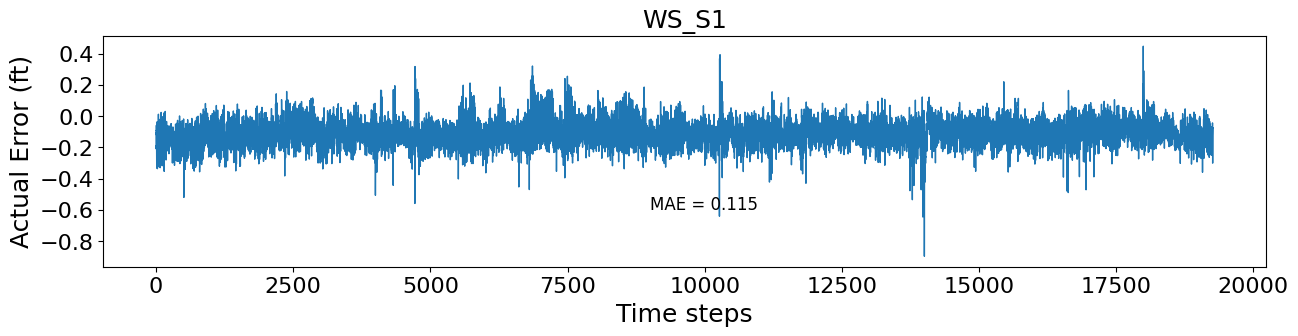

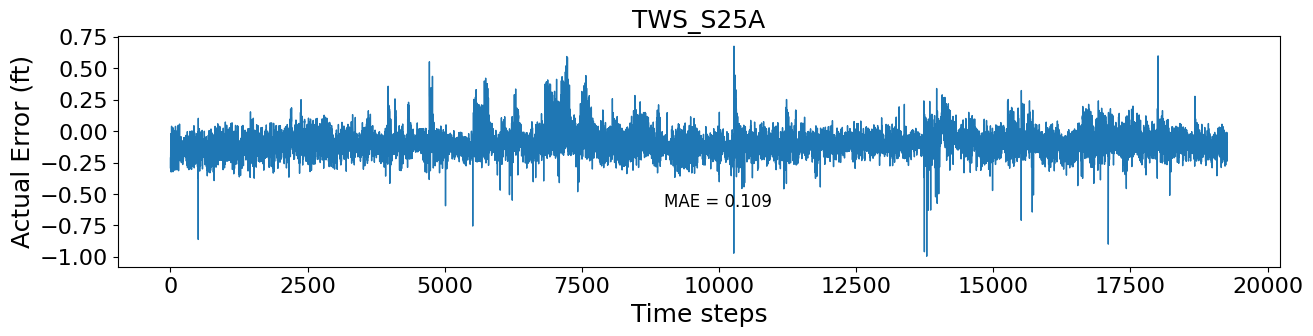

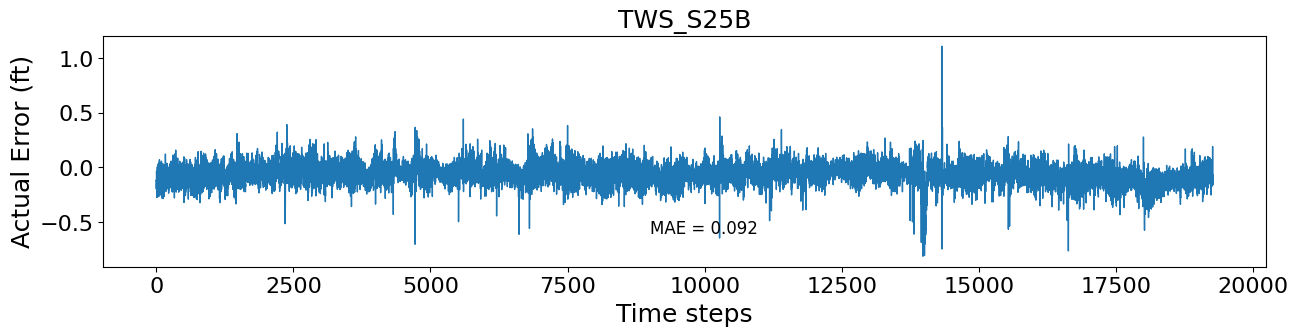

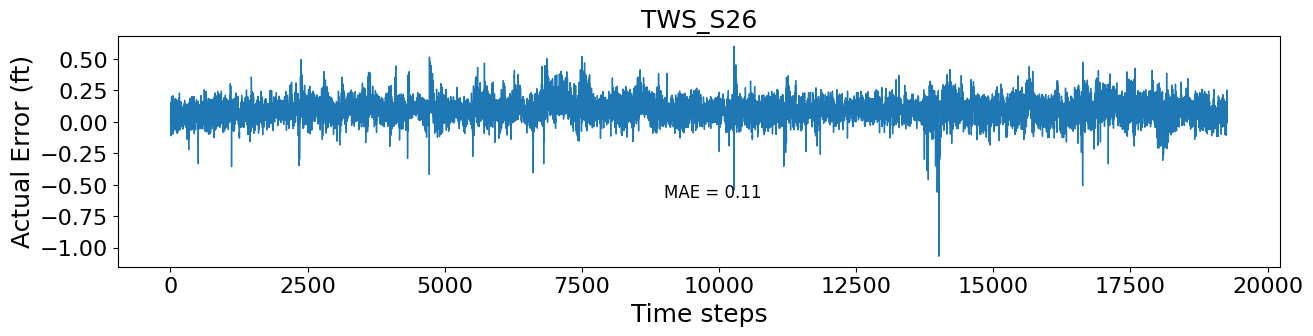

In [12]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [13]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
10
(19268,)
27
(19268,)
35
(19268,)
15


In [14]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
0
(19268,)
7
(19268,)
2
(19268,)
6


In [15]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
10
(19268,)
20
(19268,)
33
(19268,)
9
